# 1. Hello LazySlide  

## 1.1 加载 slide 数据

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwarg

WSI: data/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /home/zql/code/lazy_slide/data/GTEX-1117F-0526.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
└── Shapes
      └── 'tissues': GeoDataFrame shape: (2, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tissues (Shapes)
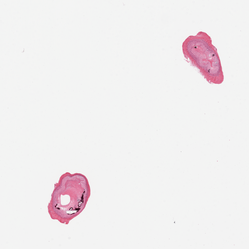

In [2]:
from wsidata import open_wsi

slide = "data/GTEX-1117F-0526.svs"
wsi = open_wsi(slide)
wsi

## 1.2 可视化

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


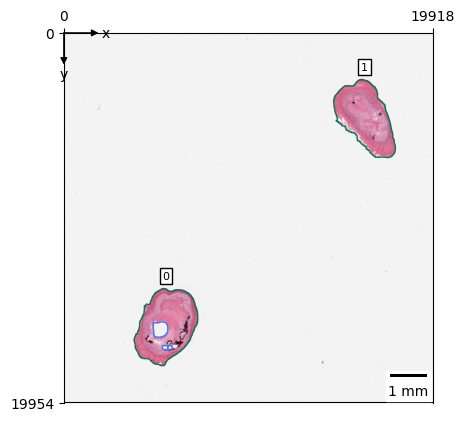

In [3]:
import lazyslide as zs

zs.pl.tissue(wsi)

## 1.3 探索金字塔结构

您会注意到这张幻灯片的金字塔中有 3 个级别，当向上移动金字塔时（随着级别数字的增加），会看到：

1. 图像尺寸（高度和宽度）逐渐变小
2. 下采样因子逐渐变大

In [4]:
wsi.fetch.pyramids()

,height,width,downsample
level,,,
0,19958,19919,1.000000
1,4989,4979,4.000502
2,2494,2489,8.002609


## 1.4 了解 WSI 属性

现在让我们探讨一下整个幻灯片图像的重要属性。这些属性提供了有关图像尺寸、分辨率和其他对分析至关重要的特征的基本信息。

1. `shape`：全分辨率图像的尺寸（以像素为单位），以 `[width， height]` 形式提供。

2. `n_level`：图像金字塔中可用的分辨率级别数，包括完整分辨率。

3. `level_shape`：金字塔中每个级别的尺寸列表，从全分辨率到最低分辨率。

4. `level_downsample`：与全分辨率相比，每个级别的缩减采样因子，指示每个级别缩小了多少。

5. `mpp`（微米每像素）：一个像素的物理尺寸，以微米为单位，表示扫描分辨率。

6. 放大倍率 ：扫描过程中使用的光学放大倍数，有助于了解捕获图像的比例。

7. `bounds`：定义幻灯片上图像区域的边界框的坐标，以 `[x， y， width， height]` 的形式提供。

In [5]:
wsi.properties

Field,Value
shape,"[19958, 19919]"
n_level,3
level_shape,"[[19958, 19919], [4989, 4979], [2494, 2489]]"
level_downsample,"[1.0, 4.000501706284455, 8.002609074152414]"
mpp,0.4942
magnification,20.0
bounds,"[0, 0, 19919, 19958]"


## 1.5 保存

In [6]:
wsi.write()

---

# 2. 预处理 

1. 加载和检查 WSI 数据
2. 从背景分割组织区域
3. 从大型 WSI 创建小的 patch
4. 从小的 patch 提取特征

## 2.1 组织分割

In [7]:
zs.pp.find_tissues(wsi)

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/spatialdata/_core/_elements.py:108: UserWarning: Key `tissues` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


绿线显示检测到的组织区域的边界，蓝色区域表示组织内将从分析中排除的孔或空白。

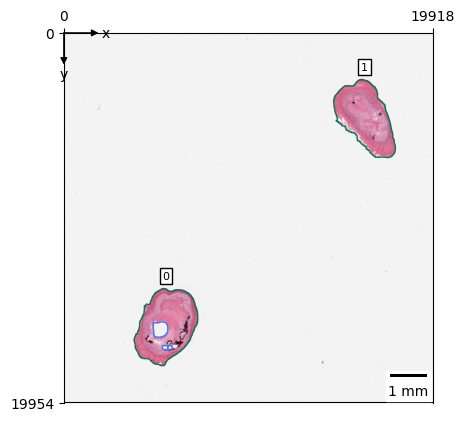

In [8]:
zs.pl.tissue(wsi)

组织分割算法的默认参数通常适用于大多数载玻片，但 LazySlide 提供了许多选项来根据需要微调分割。

## 2.2 检查分割结果

再次检查 WSIData 对象，会注意到一些新内容：名为 tissues 的 GeoDataFrame 已添加到 SpatialData 对象的 Shapes 插槽中。这是 LazySlide 存储有关我们识别的每个组织区域的几何信息的地方。

WSI: data/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /home/zql/code/lazy_slide/data/GTEX-1117F-0526.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
└── Shapes
      └── 'tissues': GeoDataFrame shape: (2, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tissues (Shapes)
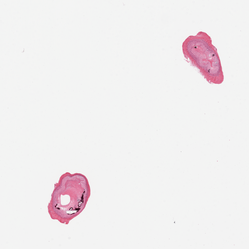

In [9]:
wsi

此表中的每一行代表一个不同的组织片段，并且每个组织都分配了一个唯一的 tissue_id。此标识符非常有用，因为它允许我们：

1. 在我们的分析中参考特定的组织片段
2. 跟踪不同加工步骤的组织碎片
3. 将作应用于单个组织而不是整个载玻片

In [10]:
wsi["tissues"]

,tissue_id,geometry
0,0,"POLYGON ((5345.743 13804.501, 5337.74 13812.50..."
1,1,"POLYGON ((16029.226 2520.822, 16021.223 2528.8..."


## 2.3 专注于单个组织碎片

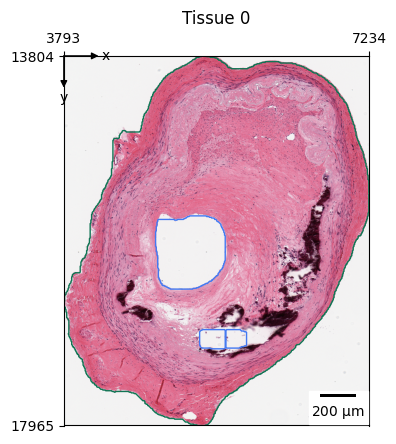

In [11]:
zs.pl.tissue(wsi, tissue_id=0)

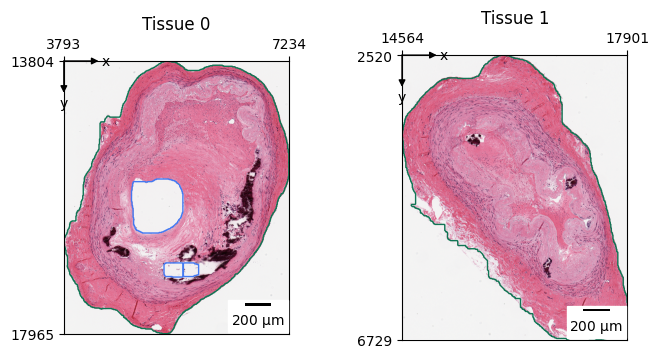

In [12]:
zs.pl.tissue(wsi, tissue_id="all")

In [13]:
wsi.write()

In [14]:
# 加载以前的工作
wsi = open_wsi(slide)

version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


---

# 3. 基于深度学习的组织分割

In [15]:
# 显式指定模型路径，确保本地加载而不是从网上下载
zs.seg.tissue(
    wsi,
    key_added="dl-tissues",
    model_path="./models/pathprofiler_tissue_seg_jit.pt"
)

WSI: data/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /home/zql/code/lazy_slide/data/GTEX-1117F-0526.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
└── Shapes
      ├── 'dl-tissues': GeoDataFrame shape: (2, 2) (2D shapes)
      └── 'tissues': GeoDataFrame shape: (2, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), dl-tissues (Shapes), tissues (Shapes)
with the following elements not in the Zarr store:
    ▸ dl-tissues (Shapes)
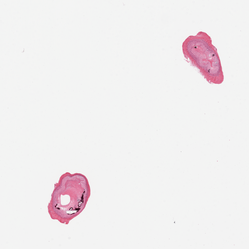

In [16]:
wsi

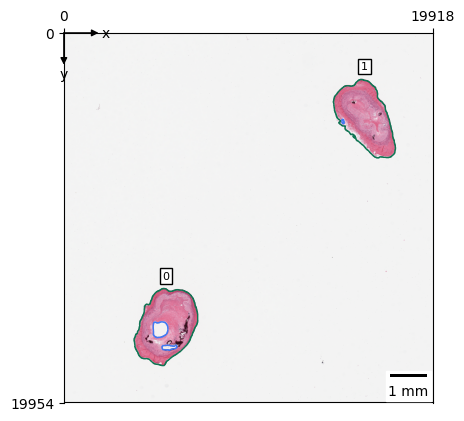

In [17]:
# 可视化上一步的分割结果
zs.pl.tissue(wsi, tissue_key="dl-tissues")

## 3.1 计算组织特性

LazySlide 可以轻松计算每个组织实例的全面几何属性，包括：

1. 面积和周长
2. 紧凑度和圆形度
3. 主轴和副皱长度
4. 方向和偏心率

In [18]:
zs.tl.tissue_props(wsi)

In [19]:
wsi["tissues"]

,tissue_id,geometry,area,area_filled,convex_area,solidity,convexity,axis_major_length,axis_minor_length,eccentricity,...,moment-mu21,moment-mu12,moment-mu03,moment-nu20,moment-nu11,moment-nu02,moment-nu30,moment-nu21,moment-nu12,moment-nu03
0,0,"POLYGON ((5345.743 13804.501, 5337.74 13812.50...",9295453.0,9962045.0,10318845.0,0.900823,1.110096,4348.672363,2953.654297,0.733946,...,1.881723e+14,-5.012970e+14,6.182167e+13,0.068301,-0.026006,0.104072,0.000592,0.000601,-0.001600,0.000197
1,1,"POLYGON ((16029.226 2520.822, 16021.223 2528.8...",8684173.0,8684173.0,9086193.5,0.955755,1.046293,4684.261719,2505.699219,0.844904,...,6.244954e+14,1.792367e+15,1.164329e+15,0.074724,0.048856,0.123623,-0.002956,0.002810,0.008065,0.005239


## 3.2 分块处理

将大的全切片图像分割成更小、更易于管理的部分，以便可以单独处理。

分块化解决了WSI分析中的几个关键挑战：

- 内存限制：全切片图像极其庞大，通常无法完全加载到内存中
- 计算效率：处理较小的分块可以实现并行计算，加快分析速度
- 特征提取：大多数深度学习模型需要固定大小的输入，分块格式适合特征提取
- 局部分析：分块化既能保留空间信息，又便于对关注区域进行精细分析

默认情况下，分块创建时不重叠以避免冗余。所有用于分块处理的参数都存储在一个 tile_spec 对象中，这有助于在分析中保持一致性和可重复性。让我们看看这个规范看起来像什么：

In [20]:
zs.pp.tile_tissues(wsi, 256, mpp=0.5)
wsi.tile_spec("tiles")

Tile at 0.5 mpp, 256×256 (h×w)
Stride: 256×256 (0×0 overlap)
Operation size: 259×259, level=0
Base size: 259×259, level=0
Target tissue: 'tissues'

可以选择分块的大小（像素为单位，此处为 256x256）和放大倍数（此处为 0.5 mpp），这些参数会影响分块的数量与细节表现：
1. 高倍镜配合小分块时，会生成大量覆盖细小区域的分块，展现出更丰富的组织细节。
2. 低倍镜配合大分块时，生成的分块数量较少，但每片覆盖更大组织区域，便于整体结构观察。

LazySlide 允许您通过指定重叠量（从 0 到 1）或步长大小（相邻瓦片起始点之间的距离）来控制重叠程度。步长小于瓦片大小时会创建重叠瓦片：

In [21]:
# If use overlap
zs.pp.tile_tissues(wsi, 256, overlap=0.1, mpp=0.5, key_added="tile_overlap_0.1")
wsi.tile_spec("tile_overlap_0.1")

Tile at 0.5 mpp, 256×256 (h×w)
Stride: 230×230 (26×26 overlap)
Operation size: 259×259, level=0
Base size: 259×259, level=0
Target tissue: 'tissues'

In [22]:
# If use stride_px
zs.pp.tile_tissues(wsi, 256, stride_px=200, mpp=0.5, key_added="tile_stride_200")
wsi.tile_spec("tile_stride_200")

Tile at 0.5 mpp, 256×256 (h×w)
Stride: 200×200 (56×56 overlap)
Operation size: 259×259, level=0
Base size: 259×259, level=0
Target tissue: 'tissues'

瓦片处理后，LazySlide 将所有瓦片信息存储在 GeoDataFrame （默认命名为 tiles ） 中，每个瓦片通过 tissue_id 列与其父组织相链接，保持了组织与瓦片之间的层级关系。让我们查看瓦片数据：



In [23]:
wsi["tiles"]

,tile_id,tissue_id,geometry
0,0,0,"POLYGON ((4052 16394, 4052 16653, 3793 16653, ..."
1,1,0,"POLYGON ((4052 16653, 4052 16912, 3793 16912, ..."
2,2,0,"POLYGON ((4311 15617, 4311 15876, 4052 15876, ..."
3,3,0,"POLYGON ((4311 15876, 4311 16135, 4052 16135, ..."
4,4,0,"POLYGON ((4311 16135, 4311 16394, 4052 16394, ..."
...,...,...,...
248,248,1,"POLYGON ((17672 5887, 17672 6146, 17413 6146, ..."
249,249,1,"POLYGON ((17672 6146, 17672 6405, 17413 6405, ..."
250,250,1,"POLYGON ((17672 6405, 17672 6664, 17413 6664, ..."
251,251,1,"POLYGON ((17931 5887, 17931 6146, 17672 6146, ..."


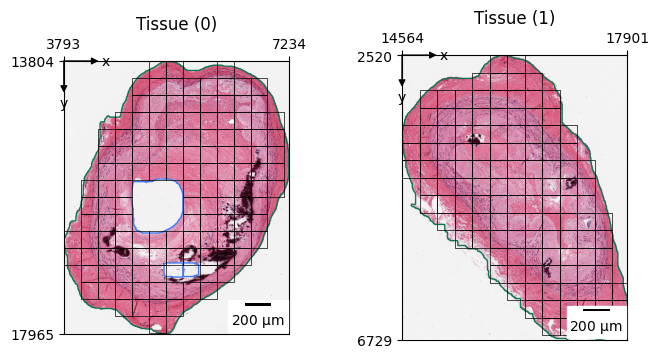

In [24]:
zs.pl.tiles(wsi, tissue_id="all", linewidth=0.5)

## 3.3 评估分块中包含的信息量

之前评估了整个组织区域的质量一样，我们也可以评估单个瓦片的质量。这尤其重要，因为并非所有瓦片都具有同等的信息量或适合进行分析。有些瓦片可能是：

1. 失焦
2. 包含扫描伪影
3. 对比度差
4. 大部分为空白

LazySlide 提供了专门为瓦片设计的预测模型。让我们应用 pathprofiler 提供的 QC 模型：

In [25]:
zs.tl.tile_prediction(wsi, 'pathprofilerqc', model_path="./models/pathprofiler_patch_quality_jit.pt")

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [26]:
wsi["tiles"]

,tile_id,tissue_id,geometry,diagnostic_quality,visual_cleanliness,focus_issue,staining_issue,tissue_folding_present,misc_artifacts_present
0,0,0,"POLYGON ((4052 16394, 4052 16653, 3793 16653, ...",0.212336,-0.052783,0.318712,0.267212,0.003917,0.743452
1,1,0,"POLYGON ((4052 16653, 4052 16912, 3793 16912, ...",0.158008,-0.020649,0.271958,0.252672,-0.042287,0.839000
2,2,0,"POLYGON ((4311 15617, 4311 15876, 4052 15876, ...",0.036022,-0.043865,0.180264,0.249866,0.014035,0.907207
3,3,0,"POLYGON ((4311 15876, 4311 16135, 4052 16135, ...",0.087806,-0.023344,0.206562,0.203999,0.028831,0.832728
4,4,0,"POLYGON ((4311 16135, 4311 16394, 4052 16394, ...",0.043823,-0.016826,0.156495,0.159363,0.010395,0.867100
...,...,...,...,...,...,...,...,...,...
248,248,1,"POLYGON ((17672 5887, 17672 6146, 17413 6146, ...",0.246705,0.063792,0.077589,0.355229,0.022990,0.569532
249,249,1,"POLYGON ((17672 6146, 17672 6405, 17413 6405, ...",-0.034058,0.002493,0.051499,0.194301,0.007260,0.886168
250,250,1,"POLYGON ((17672 6405, 17672 6664, 17413 6664, ...",0.170891,0.018947,0.088540,0.259233,0.003888,0.737062
251,251,1,"POLYGON ((17931 5887, 17931 6146, 17672 6146, ...",0.072004,-0.048162,0.175226,0.202904,0.005962,0.975136


## 3.4 可视化瓦片质量分数

计算质量分数后，可视化它们有助于识别模式或问题区域。LazySlide 通过允许您根据瓦片数据框中的任何数值属性为瓦片上色，使这一操作变得简单。

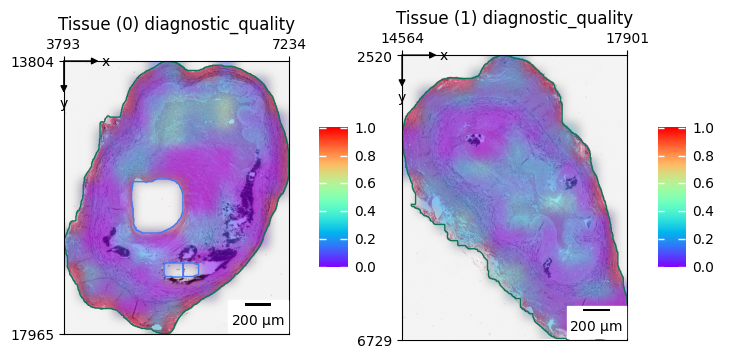

In [27]:
zs.pl.tiles(wsi, tissue_id="all", color="diagnostic_quality", cmap="rainbow", 
            smooth=True, alpha=.5, vmin=0, vmax=1)

## 3.5 特征提取 - 将图像转换为数值表示

这个过程将我们的图像瓦片转换为数值表示（特征向量），以捕捉组织的形态特征。

特征提取至关重要，因为：

- 它将复杂的视觉信息转换为机器学习算法可以处理的格式
- 它能够实现不同组织区域之间的定量比较
- 它是分类、聚类和异常检测等任务的基础

### 3.5.1 使用视觉模型进行特征提取

从组织学图像中提取有意义特征最有效的方法是使用预训练的视觉模型。这些模型通常在数百万张图像上进行训练，已经学会了识别与许多视觉任务相关的模式和结构。

LazySlide 支持多种视觉模型：

- 来自 timm 库的标准架构（ResNet、DenseNet、EfficientNet 等）
- 专门用于病理学的基座模型
- 可提供的自定义模型

您可以使用以下方式探索可用的 timm 模型：

In [28]:
import timm
timm.list_models()

['aimv2_1b_patch14_224',
 'aimv2_1b_patch14_336',
 'aimv2_1b_patch14_448',
 'aimv2_3b_patch14_224',
 'aimv2_3b_patch14_336',
 'aimv2_3b_patch14_448',
 'aimv2_huge_patch14_224',
 'aimv2_huge_patch14_336',
 'aimv2_huge_patch14_448',
 'aimv2_large_patch14_224',
 'aimv2_large_patch14_336',
 'aimv2_large_patch14_448',
 'bat_resnext26ts',
 'beit3_base_patch16_224',
 'beit3_giant_patch14_224',
 'beit3_giant_patch14_336',
 'beit3_large_patch16_224',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'beitv2_base_patch16_224',
 'beitv2_large_patch16_224',
 'botnet26t_256',
 'botnet50ts_256',
 'caformer_b36',
 'caformer_m36',
 'caformer_s18',
 'caformer_s36',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_medium',
 'coat_lite_medium_384',
 'coat_lite_mini',
 'coat_lite_sma

### 3.5.2 使用基础模型进行特征提取

虽然像 ResNet50 这样的通用视觉模型在许多任务上表现良好，但 LazySlide 还提供了专门针对组织学图像进行训练的基础模型。这些模型通常能更有效地捕捉病理学特定特征。

In [29]:
zs.models.list_models()[0:8]

['conch',
 'musk',
 'omiclip',
 'plip',
 'prism',
 'titan',
 'conch_v1.5',
 'cellpose']

In [33]:
zs.tl.feature_extraction(wsi, "uni2", model_path="./models/uni2-h/pytorch_model.bin")

/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

WSI: data/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object, with associated Zarr store: /home/zql/code/lazy_slide/data/GTEX-1117F-0526.zarr
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
├── Shapes
│     ├── 'dl-tissues': GeoDataFrame shape: (2, 2) (2D shapes)
│     ├── 'tile_overlap_0.1': GeoDataFrame shape: (311, 3) (2D shapes)
│     ├── 'tile_stride_200': GeoDataFrame shape: (415, 3) (2D shapes)
│     ├── 'tiles': GeoDataFrame shape: (253, 9) (2D shapes)
│     └── 'tissues': GeoDataFrame shape: (2, 51) (2D shapes)
└── Tables
      └── 'uni2_tiles': AnnData (253, 1536)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), dl-tissues (Shapes), tile_overlap_0.1 (Shapes), tile_stride_200 (Shapes), tiles (Shapes), tissues (Shapes)
with the following elements not in the Zarr store:
    ▸ tile_stride_200 (Shapes)
    ▸ uni2_tiles (Tables)
    ▸ tile_overlap_0.1 (Shapes)
    ▸ tiles (Shapes)
    ▸ dl-tissues (Shapes)
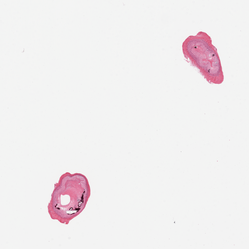

In [34]:
wsi